<a href="https://colab.research.google.com/github/aliakbarbadri/natural-language-inference/blob/master/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU, TimeDistributed
import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

Using TensorFlow backend.


# Load and Preprocess the data

In [2]:
source = pd.read_pickle(r'https://github.com/aliakbarbadri/natural-language-inference/blob/master/hypotheses_train.pickle?raw=true')
target = pd.read_pickle(r'https://github.com/aliakbarbadri/natural-language-inference/blob/master/premises_train.pickle?raw=true')

In [3]:
print(source[0])
print(target[0])

A person is outdoors , on a horse .
A person on a horse jumps over a broken down airplane .


In [4]:
lines_main = pd.DataFrame(
    {'source': source,
     'target': target
     })

In [5]:
lines_main.shape

(183416, 2)

In [6]:
lines = lines_main[:50000]

In [7]:
lines.shape

(50000, 2)

In [8]:
# Lowercase all characters
lines.source=lines.source.apply(lambda x: x.lower())
lines.target=lines.target.apply(lambda x: x.lower())

# Remove quotes
lines.source=lines.source.apply(lambda x: re.sub("'", '', x))
lines.target=lines.target.apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines.source=lines.source.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.target=lines.target.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.source=lines.source.apply(lambda x: x.translate(remove_digits))
lines.target=lines.target.apply(lambda x: x.translate(remove_digits))

# Remove extra spaces
lines.source=lines.source.apply(lambda x: x.strip())
lines.target=lines.target.apply(lambda x: x.strip())
lines.source=lines.source.apply(lambda x: re.sub(" +", " ", x))
lines.target=lines.target.apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
lines.target = lines.target.apply(lambda x : 'START_ '+ x + ' _END')

lines.sample(10)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,source,target
3780,the people are together,START_ a group of several people are attending...
14391,a crossing guard holds up the flag,START_ a man stands on a crosswalk holding a f...
45908,a man is outside,START_ a man or older boy is standing up in a ...
19090,girl holding small house at a table with others,START_ a picture of a girl sitting at a table ...
45747,a couple of people gathering some produce,START_ two women are outside with a basket pic...
8298,a girl is playing a game,START_ a little girl is playing the derby game...
39257,the two dogs are chasing each other,START_ two golden dogs playing with one anothe...
12709,a woman and children are playing,START_ a woman and children are playing in a w...
33063,it is sunny,START_ a man sits on a sailboat with the sun s...
25540,someone is kneeling,START_ one mountaineer is kneeling on the grou...


In [9]:
all_words_source=set()
for line in lines.source:
    for word in line.split():
        if word not in all_words_source:
            all_words_source.add(word)

all_words_target=set()
for line in lines.target:
    for word in line.split():
        if word not in all_words_target:
            all_words_target.add(word)

In [10]:
lenght_list=[]
for l in lines.source:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)

lenght_list=[]
for l in lines.target:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)

max_length_src, max_length_tar

(43, 80)

In [11]:
input_words = sorted(list(all_words_source))
target_words = sorted(list(all_words_target))

num_encoder_tokens = len(all_words_source)
num_decoder_tokens = len(all_words_target)

num_encoder_tokens, num_decoder_tokens

(8691, 11412)

In [12]:
num_decoder_tokens += 1 # For zero padding
num_decoder_tokens

11413

In [13]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [14]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [15]:
lines = shuffle(lines)
lines.head(10)

,source,target
23767,the girl is wearing a green shirt,START_ a girl in a green shirt with long dark ...
17679,a person in blue,START_ a small child dressed all in blue for w...
2389,two motorcyclist racing,START_ two motorcyclist racing on an inclined ...
42259,people are starting a race,START_ five men wearing black shorts are leavi...
2644,seven men are working with tools,START_ seven men chipping tiles with hammers _END
37967,the boy splashed the water,START_ the boy splashed the water _END
8853,two older men are using binoculars,START_ two older men are wearing outdoor cloth...
35550,a man and child are sitting,START_ man and child sitting on a front set of...
48708,a man is looking at a container,START_ man in orange coat stood on a ladder in...
42528,while looking at the camera a lady who wore an...,START_ a woman wearing an orange scarf smiles ...


In [16]:
# Train - Test Split
X, y = lines.source, lines.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, X_test.shape

((40000,), (10000,))

In [17]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

In [18]:
def generate_batch(X = X_train, y = y_train, batch_size = 64):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

# Model

In [19]:
latent_dim = 50

In [20]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [21]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [22]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

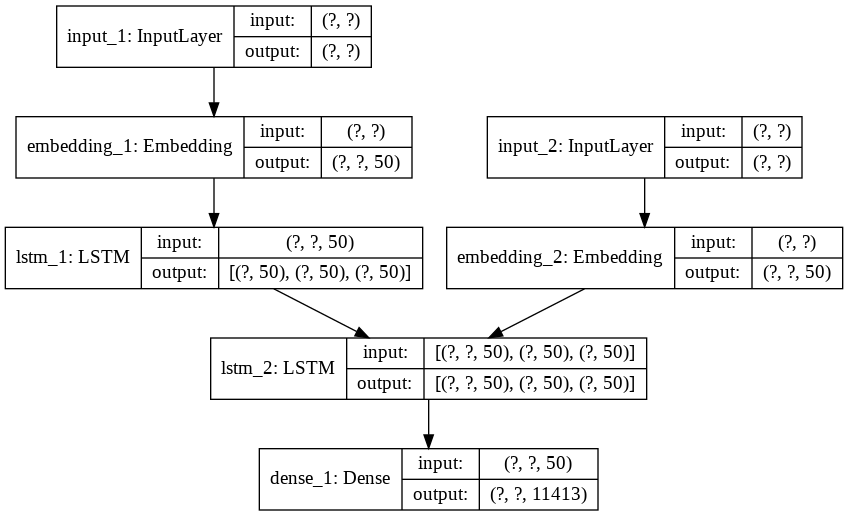

In [23]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [27]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 32
epochs = 10

In [29]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=3,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/3
1250/1250 [==============================] - 473s 379ms/step - loss: 0.7328 - acc: 0.2957 - val_loss: 0.7353 - val_acc: 0.3072
Epoch 2/3
1250/1250 [==============================] - 472s 378ms/step - loss: 0.6996 - acc: 0.3201 - val_loss: 0.6999 - val_acc: 0.3260
Epoch 3/3
1250/1250 [==============================] - 470s 376ms/step - loss: 0.6795 - acc: 0.3345 - val_loss: 0.7153 - val_acc: 0.3375


In [30]:
# model.save_weights('seq2seq_model.h5')

In [31]:
# model = model.load_weights('seq2seq_model.h5')

In [32]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [33]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [34]:
train_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [35]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input:', X_train[k:k+1].values[0])
print('Actual:', y_train[k:k+1].values[0][6:-4])
print('Predicted:', decoded_sentence[:-4])

Input English sentence: a photographer take a photo
Actual Marathi Translation:  a photographer captures the beauty of a river 
Predicted Marathi Translation:  a man in a blue shirt is standing on a bench 
